In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.cross_validation import KFold

C:\Users\ssimo\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### Домашнее задание №1: визуализация, k-NN регрессия, кросс-валидация.

В этом задании мы рассмотрим задачу прогнозирования количества взятых в аренду велосипедов.

Файл [bike_sharing.csv](https://yadi.sk/d/n8iy_trO3EsUBa) содержит данные о 731 дне работы сервиса по аренде велосипедов. Про каждый день известны:
* instant: record index
* dteday : date
* season : season (1:springer, 2:summer, 3:fall, 4:winter)
* yr : year (0: 2011, 1:2012)
* mnth : month ( 1 to 12)
* holiday : weather day is holiday or not (extracted from http://dchr.dc.gov/page/holiday-schedule)
* weekday : day of the week
* workingday : if day is neither weekend nor holiday is 1, otherwise is 0.
* weathersit :
   + 1: Clear, Few clouds, Partly cloudy, Partly cloudy
   + 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
   + 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
   + 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
* temp : Normalized temperature in Celsius from 0 to 100.
* atemp: Normalized feeling temperature in Celsius from 0 to 100.
* hum: Normalized humidity. The values are divided to 100 (max)
* windspeed: Normalized wind speed. The values are divided to 67 (max)
* casual: count of casual users
* registered: count of registered users
* cnt: count of total rental bikes including both casual and registered

**1. (0.25 балла)** Откройте файл bike_sharing.csv, запишите в датафрейм df и выведите первые пять строк датафрейма.

In [2]:
df = pd.read_csv("D:/bike_sharing.csv")
df.head()

,Unnamed: 0,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,0,1,2011-01-01,1,0,1,0,6,0,2,34.4167,36.3625,0.805833,0.160446,331,654,985
1,1,2,2011-01-02,1,0,1,0,0,0,2,36.3478,35.3739,0.696087,0.248539,131,670,801
2,2,3,2011-01-03,1,0,1,0,1,1,1,19.6364,18.9405,0.437273,0.248309,120,1229,1349
3,3,4,2011-01-04,1,0,1,0,2,1,1,20.0000,21.2122,0.590435,0.160296,108,1454,1562
4,4,5,2011-01-05,1,0,1,0,3,1,1,22.6957,22.9270,0.436957,0.186900,82,1518,1600


**2. (1 балл)** Постройте график среднего числа арендованных байков (cnt) по каждому месяцу. Не забудьте подписать оси координат. Убедитесь, что в летние месяцы велосипеды в прокат берут чаще.

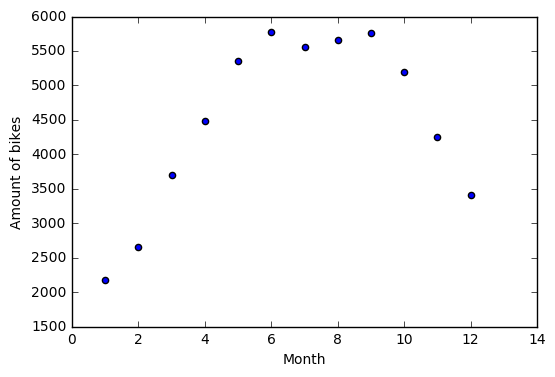

In [3]:
a = df.groupby('mnth')['cnt'].mean() 

plt.scatter([i for i in range(1, 13)], a) 
plt.xlabel('Month') 
plt.ylabel('Amount of bikes')

**3. (0.5 балла)** Постройте диаграмму рассеяния (scatter plot) с осями cnt и atemp, где точки — это объекты. Какой логичный вывод можно сделать по этому графику?

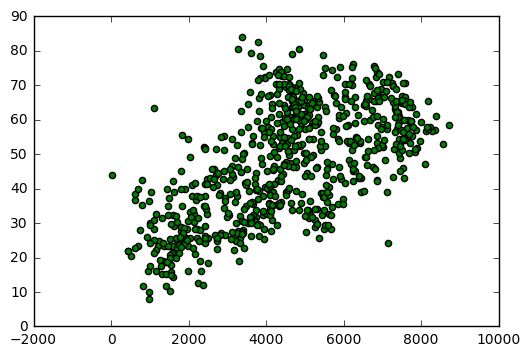

In [4]:
plt.scatter(df.cnt, df.atemp, c='g')

ylabel = 'Average temperature'
xlabel = 'Amount of bikes'

*Вывод:* больше велосипедов арендуют при более теплой погоде (но не слишком жаркой), "золотая середина" примерно в 60 градусах.

**4. (0.5 балла)** Преобразуйте небинарные категориальные признаки с помощью one-hot кодирования. Сделать это можно с помощью функции pd.get_dummies, указав нужные столбцы в параметре columns. Сколько признаков получилось после кодирования? И какой категориальный признак породил больше всего бинарных?

In [5]:
new_df = pd.get_dummies(df, columns=['season', 'mnth', 'weathersit'])

print('Было признаков: ' + str(len(df.columns)-1) + '\nТеперь признаков: ' + str(len(new_df.columns)-1))
#вычитаем 1 из-за первой колонки, которая не признак, а просто порядковый номер

Было признаков: 16
Теперь признаков: 32


*Какой категориальный признак породил больше всего бинарных?* Больше всего бинарных породил признак "mnth", потому что он содержит больше всего категорий

**5. (0.25 балла)** Удалите столбцы instant, dteday, casual и registered. Предположите, почему мы удаляем эти признаки.

In [6]:
del new_df['instant']
del new_df['dteday']
del new_df['casual']
del new_df['registered']
new_df.head()

,Unnamed: 0,yr,holiday,weekday,workingday,temp,atemp,hum,windspeed,cnt,...,mnth_6,mnth_7,mnth_8,mnth_9,mnth_10,mnth_11,mnth_12,weathersit_1,weathersit_2,weathersit_3
0,0,0,0,6,0,34.4167,36.3625,0.805833,0.160446,985,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1,0,0,0,0,36.3478,35.3739,0.696087,0.248539,801,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,2,0,0,1,1,19.6364,18.9405,0.437273,0.248309,1349,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,3,0,0,2,1,20.0000,21.2122,0.590435,0.160296,1562,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,4,0,0,3,1,22.6957,22.9270,0.436957,0.186900,1600,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


*Мы удаляем эти признаки, потому что они не нужны нам в последующих исследованиях: instant и dtday вообще не несут никакой смысловой нагрузки, а разделением на casual и registered для наших целей можно и пренебречь*

**6. (0.5 балла)** Далее нашей целевой переменной будет количество арендованных велосипедов (cnt). Поэтому запишите cnt в переменную df_ans и удалите из df. Затем в помощью функции train_test_split из sklearn.model_selection разделите выборку на обучающую и контрольную в отношении 7 к 3, создав переменные X_train, X_test, y_train, y_test.

Замечание 1: установите random_seed, чтобы генератор псевдослучайных чисел работал всегда одинаково.

Замечание 2: если в sklearn.model_selection нет функции train_test_split, обновите scikit-learn.

In [7]:
df_ans = new_df['cnt']
safe_df = new_df
del new_df['cnt']
X_train, X_test, y_train, y_test = train_test_split(new_df, df_ans, test_size=0.3, random_state=42)

**7. (1 балл)** Обучите алгоритм пяти ближайших соседей с евклидовой метрикой и оцените MAE на контрольной выборке.

In [8]:
knn = KNeighborsRegressor(n_neighbors=5, metric='euclidean')
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

In [9]:
MAE = mean_absolute_error(y_pred, y_test)
print('MAE =', MAE)

MAE = 623.965454545


**8. (0.5 балла)** Постройте диаграмму рассеяния (scatter plot), по одной оси отметив настоящее число аренд велосипедов, а по другой — предсказанное алгоритмом. Дополнительно на этом графике постройте прямую $y = x$. Чему соотстветствует отклонение от этой прямой?

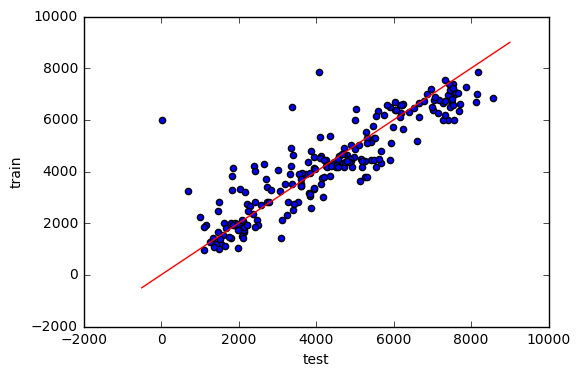

In [10]:
plt.scatter(y_test, y_pred)
plt.xlabel('test')
plt.ylabel('train')
plt.plot([-500, 9000], [-500, 9000], c='r')

**9. (1 балл)** Отмасштабируйте признаки, чтобы они принимали значения на $[0, 1]$.

Это можно сделать собственноручно с помощью операций pandas.

Иначе — можно использовать MinMaxScaler из sklearn.preprocessing — класс с методами fit и transform. Для этого:

* либо соедините X_train и X_test обратно в единый датафрейм, отмасштабируйте и разъедините обратно,
* либо отмасштабируйте df (без ответов) и разделите на обучающую и контрольную выборку, используя тот же random_seed.

На выходе метода transform получится numpy-массив, который нужно будет превратить обратно в датафрейм.

In [11]:
min_max_scaler = MinMaxScaler()
sc_df = min_max_scaler.fit_transform(new_df)
df3 = pd.DataFrame(sc_df)
X_train1, X_test1 = train_test_split(df3, test_size=0.3, random_state=42)

**10. (0.5 балла)** Вновь обучите алгоритм пяти ближайших соседей с евклидовой метрикой и оцените MAE на контрольной выборке. Почему качество поменялось?

new MAE = 659.297272727


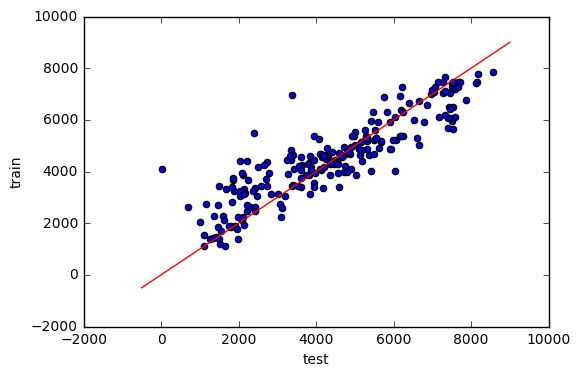

In [13]:
knn.fit(X_train1, y_train)
y_pred1 = knn.predict(X_test1)
newMAE = mean_absolute_error(y_pred1, y_test)
print('new MAE =', newMAE)

plt.scatter(y_test, y_pred1)
plt.xlabel('test')
plt.ylabel('train')
plt.plot([-500, 9000], [-500, 9000], c='r')

Качество поменялось, потому что мы поменяли данные

**11. (1.25 балла)** Используя класс KFold из sklearn.model_selection установите с помощью кросс-валидации на пяти фолдах, какой параметр weights лучше с точки зрения mean absolute error.

In [15]:
kf = KFold(df3.shape[0], n_folds=5)
knn_dist = KNeighborsRegressor(n_neighbors=5, metric='euclidean', weights='distance')
for train, test in kf:
    knn.fit(df3[train], df_ans[train])
    y_pred2[test] = knn.predict(df3[test])
    knn_dist.fit(df3[train], df_ans[train])
    y_pred3[test] = knn_dist.predict(df3[test])
defMAE = mean_absolute_error(y_pred2, y_test)
distMAE = mean_absolute_error(y_pred3, y_test)

print('MAE1:', defMAE, '\nMAE2:', distMAE)

KeyError: '[147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164\n 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182\n 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200\n 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218\n 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236\n 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254\n 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272\n 273 274 275 276 277 278 279 280 281 282 283 284 285 286 287 288 289 290\n 291 292 293 294 295 296 297 298 299 300 301 302 303 304 305 306 307 308\n 309 310 311 312 313 314 315 316 317 318 319 320 321 322 323 324 325 326\n 327 328 329 330 331 332 333 334 335 336 337 338 339 340 341 342 343 344\n 345 346 347 348 349 350 351 352 353 354 355 356 357 358 359 360 361 362\n 363 364 365 366 367 368 369 370 371 372 373 374 375 376 377 378 379 380\n 381 382 383 384 385 386 387 388 389 390 391 392 393 394 395 396 397 398\n 399 400 401 402 403 404 405 406 407 408 409 410 411 412 413 414 415 416\n 417 418 419 420 421 422 423 424 425 426 427 428 429 430 431 432 433 434\n 435 436 437 438 439 440 441 442 443 444 445 446 447 448 449 450 451 452\n 453 454 455 456 457 458 459 460 461 462 463 464 465 466 467 468 469 470\n 471 472 473 474 475 476 477 478 479 480 481 482 483 484 485 486 487 488\n 489 490 491 492 493 494 495 496 497 498 499 500 501 502 503 504 505 506\n 507 508 509 510 511 512 513 514 515 516 517 518 519 520 521 522 523 524\n 525 526 527 528 529 530 531 532 533 534 535 536 537 538 539 540 541 542\n 543 544 545 546 547 548 549 550 551 552 553 554 555 556 557 558 559 560\n 561 562 563 564 565 566 567 568 569 570 571 572 573 574 575 576 577 578\n 579 580 581 582 583 584 585 586 587 588 589 590 591 592 593 594 595 596\n 597 598 599 600 601 602 603 604 605 606 607 608 609 610 611 612 613 614\n 615 616 617 618 619 620 621 622 623 624 625 626 627 628 629 630 631 632\n 633 634 635 636 637 638 639 640 641 642 643 644 645 646 647 648 649 650\n 651 652 653 654 655 656 657 658 659 660 661 662 663 664 665 666 667 668\n 669 670 671 672 673 674 675 676 677 678 679 680 681 682 683 684 685 686\n 687 688 689 690 691 692 693 694 695 696 697 698 699 700 701 702 703 704\n 705 706 707 708 709 710 711 712 713 714 715 716 717 718 719 720 721 722\n 723 724 725 726 727 728 729 730] not in index'

*это было очень сложно :с* https://goo.gl/images/sGXGtw

**12. (2.5 балла)** С помощью GridSearchCV из sklearn.model_selection на пяти фолдах выберите лучшее значение $k$ от 1 до 50. Постройте график MAE на кросс-валидации в зависимости от $k$.

Замечание: Передать нужную метрику качества для GridSearchCV можно через параметр scoring, но не всё так просто. Из метрики качества нужно сделать «scorer» c помощью функции sklearn.metrics.make_scorer, не забыв указать нужное значение greater_is_better.

**13. (0.25 балла)** Посчитайте качество итоговой модели на контрольной выборке.